In [1]:
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import networkx as nx  # For graph algorithms
import ast  # To safely parse edge list strings into Python lists
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced plots
from sklearn.model_selection import GroupKFold, GridSearchCV  # Grouped cross-validation and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
# read training data
df = pd.read_csv('../data/train.csv')

## Inspect the Data

We inspect the train dataset to check the structure of the data and understand the dataset more. We check the summary statistics and look out for possible errors, missing values, outliers or duplicates. We also check the the datatypes of each variable and ensure they are of the proper type. 

In [4]:
df.head()

,language,sentence,n,edgelist,root
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10
1,Japanese,5,18,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...",10
2,Japanese,8,33,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...",3
3,Japanese,11,30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...",30
4,Japanese,12,19,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...",11


In [5]:
# get number of rows and columns
df.shape

(10500, 5)

Target variable: root. 
It says the node that is the root. But to make the task simpler, we will turn it to a binary classification task. Such that, each row takes a node and the target variable will the is_root, where 0 will indicate that the node isn't the root and 1 indicates that it is the root.

This will cause data imbalance in the dataset because most of the classes will be 0. 

In [7]:
# check other variables in the data
df.columns

Index(['language', 'sentence', 'n', 'edgelist', 'root'], dtype='object')

In [8]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  10500 non-null  object
 1   sentence  10500 non-null  int64 
 2   n         10500 non-null  int64 
 3   edgelist  10500 non-null  object
 4   root      10500 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 410.3+ KB


In [9]:
# Check for missing values
df.isnull().sum()

language    0
sentence    0
n           0
edgelist    0
root        0
dtype: int64

In [10]:
# Check for duplicates
df.duplicated().sum()

0

Training data contains no missing values or duplicated columns, which is good


In [12]:
# check the data types
df.dtypes

language    object
sentence     int64
n            int64
edgelist    object
root         int64
dtype: object

In [13]:
# Confirm the type of object
type(df['edgelist'].iloc[0])

str

Edgelist is of the datatype object (string).

It needs to be converted to a python edgelist which can be used to create the networkx tree

In [15]:
df.describe()

,sentence,n,root
count,10500.000000,10500.000000,10500.000000
mean,494.778000,18.807524,9.844476
std,290.256632,8.190593,7.207740
min,2.000000,3.000000,1.000000
25%,233.500000,13.000000,4.000000
50%,483.000000,18.000000,8.000000
75%,742.250000,23.000000,14.000000
max,995.000000,70.000000,68.000000


There are sentences with 3 nodes (words) and some with as many as 70 nodes. This should be taken into consideration when normalizing. it will be advisable to normalize per sentence coz of this imbalance

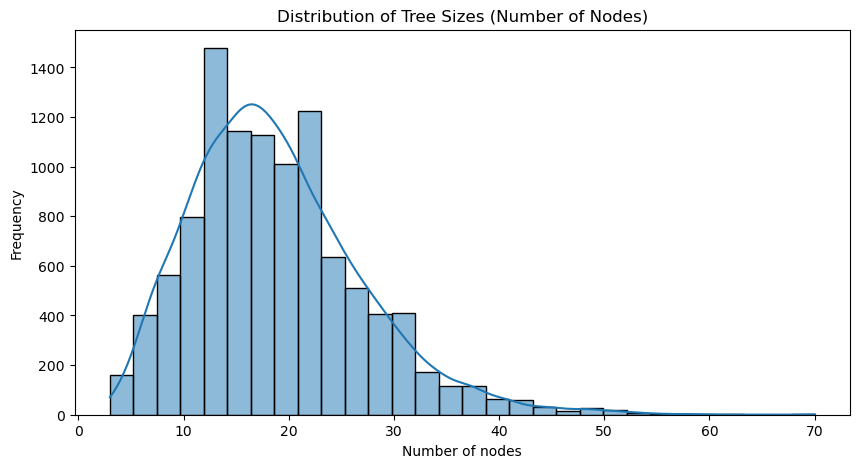

In [17]:
# Sentence length distribution
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='n', bins=30, kde=True)
plt.title('Distribution of Tree Sizes (Number of Nodes)')
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Language distribution (check number of languages and number of sentences per language)
lang = df['language'].nunique()
print(f'There are {lang} languages. Each language has the following number of sentences:')
df['language'].value_counts()

There are 21 languages. Each language has the following number of sentences:


language
Japanese      500
German        500
Arabic        500
Portuguese    500
Chinese       500
Czech         500
Turkish       500
Thai          500
Polish        500
Korean        500
Icelandic     500
Finnish       500
Spanish       500
Swedish       500
Indonesian    500
Italian       500
French        500
Hindi         500
English       500
Galician      500
Russian       500
Name: count, dtype: int64

count    10500.000000
mean         9.844476
std          7.207740
min          1.000000
25%          4.000000
50%          8.000000
75%         14.000000
max         68.000000
Name: root, dtype: float64


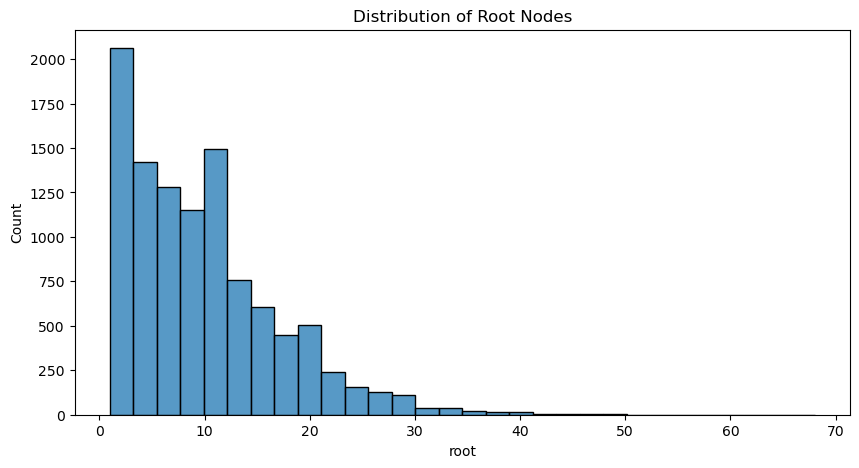

In [19]:
# Root node analysis
print(df['root'].describe())
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='root', bins=30)
plt.title('Distribution of Root Nodes')
plt.show()

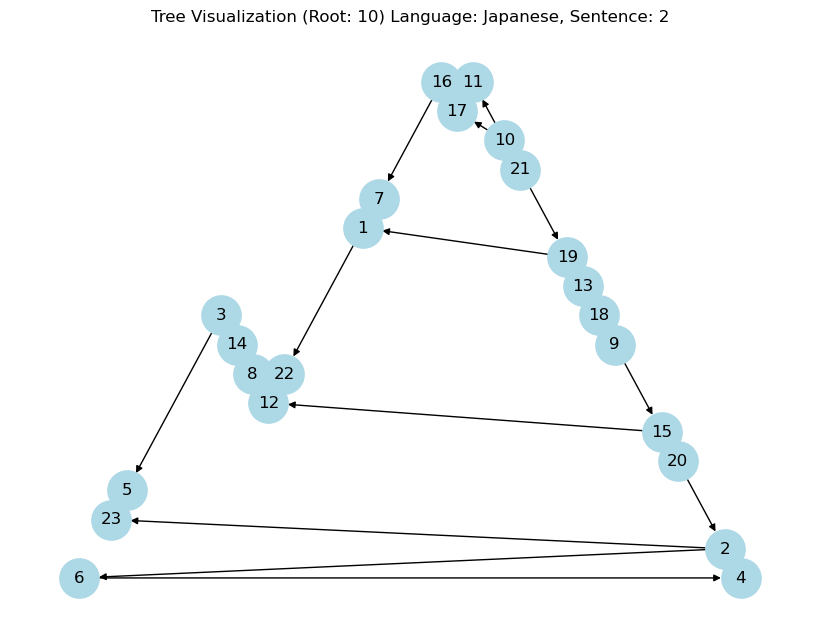

In [20]:
def visualize_tree(edges, root, title=""):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    pos = nx.planar_layout(G) if nx.is_planar(G) else nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color='lightblue')
    plt.title(f"Tree Visualization (Root: {root}) {title}")
    plt.show()

# Visualize first tree
for i, row in df.head(1).iterrows():
    visualize_tree(ast.literal_eval(row['edgelist']), row['root'], f"Language: {row['language']}, Sentence: {row['sentence']}")

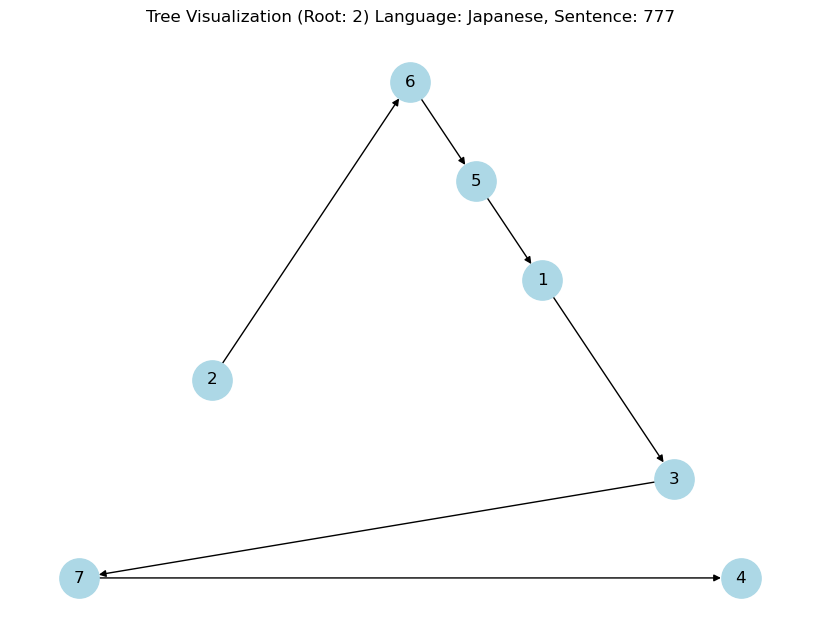

In [21]:
 visualize_tree(ast.literal_eval(df.iloc[389]['edgelist']), df.iloc[389]['root'], f"Language: {df.iloc[389]['language']}, Sentence: {df.iloc[389]['sentence']}")

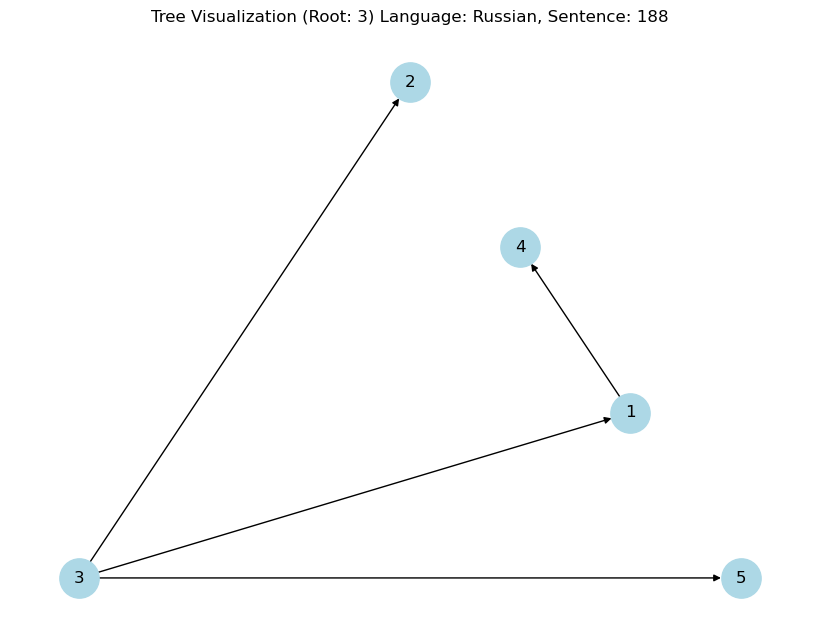

In [22]:
 visualize_tree(ast.literal_eval(df.iloc[10098]['edgelist']), df.iloc[10098]['root'], f"Language: {df.iloc[10098]['language']}, Sentence: {df.iloc[10098]['sentence']}")

## Data Preprocessing

In [24]:
import ast
import pandas as pd
import networkx as nx
import numpy as np
from scipy import stats
from collections import Counter

def preprocess(df):
    """
    Enhanced preprocessing with additional features for tree root prediction
    """
    
    df['edgelist'] = df['edgelist'].apply(ast.literal_eval)
    
    def enhanced_features(edgelist):
        """
        Extract features for tree root prediction
        """
        T = nx.from_edgelist(edgelist)
        
        # Basic centrality measures (your existing ones)
        dc = nx.degree_centrality(T)
        cc = nx.harmonic_centrality(T)
        bc = nx.betweenness_centrality(T)
        pc = nx.pagerank(T)
        clc = nx.closeness_centrality(T)
        kz = nx.katz_centrality_numpy(T, alpha=0.005, beta=1.0)
        lc = nx.load_centrality(T)
        andc = nx.average_neighbor_degree(T)
        ec = nx.eigenvector_centrality_numpy(T)
        
        # NEW FEATURES FOR ROOT PREDICTION
        
        
        # 2. Distance-based features
        # Average distance to all other nodes
        shortest_paths = dict(nx.all_pairs_shortest_path_length(T))
        sum_distances = {}
        
        for node in T.nodes():
            distances = list(shortest_paths[node].values())
            sum_distances[node] = sum(distances)
        
        # 3. Tree-specific features
        # Distance from center(s) of the tree
        periphery_nodes = nx.periphery(T)
        
        distance_from_periphery = {}
       
        for node in T.nodes():
            # Distance to closest periphery
            distance_from_periphery[node] = min(nx.shortest_path_length(T, node, periph) 
                                              for periph in periphery_nodes)
      
        # 4. Subtree size features
        # For each node, compute size of subtree when that node is removed
        subtree_sizes = {}
        for node in T.nodes():
            T_copy = T.copy()
            T_copy.remove_node(node)
            components = list(nx.connected_components(T_copy))
            # Size of largest component when node is removed
            subtree_sizes[node] = max(len(comp) for comp in components) if components else 0
        
        # 5. Neighbor-based features
        neighbor_degrees = {}
        neighbor_centralities = {}
        second_order_neighbors = {}
        
        for node in T.nodes():
            neighbors = list(T.neighbors(node))
            if neighbors:
                neighbor_degrees[node] = np.mean([T.degree(n) for n in neighbors])
                neighbor_centralities[node] = np.mean([dc[n] for n in neighbors])
                # Second-order neighbors (neighbors of neighbors)
                second_neighbors = set()
                for neighbor in neighbors:
                    second_neighbors.update(T.neighbors(neighbor))
                second_neighbors.discard(node)  # Remove self
                second_order_neighbors[node] = len(second_neighbors)
            else:
                neighbor_degrees[node] = 0
                neighbor_centralities[node] = 0
                second_order_neighbors[node] = 0
        
        
        # 7. Relative position features
        # Node's centrality relative to max centrality
        max_dc = max(dc.values())
        relative_centrality = {node: dc[node] / max_dc for node in T.nodes()}
        
        # 8. Tree depth features (if we can infer a root)
        # Use the most central node as a proxy root for depth calculation
        proxy_root = max(dc.keys(), key=lambda x: dc[x])
        depths_from_proxy = nx.single_source_shortest_path_length(T, proxy_root)
        
        # 9. Bridge and articulation point features
        bridges = list(nx.bridges(T))
        bridge_count = {node: sum(1 for bridge in bridges if node in bridge) for node in T.nodes()}
        
        # 10. Statistical features within neighborhoods
        local_degree_variance = {}
        
        for node in T.nodes():
            neighbors = list(T.neighbors(node))
            if len(neighbors) > 1:
                neighbor_degrees_list = [T.degree(n) for n in neighbors]
                local_degree_variance[node] = np.var(neighbor_degrees_list)
            else:
                local_degree_variance[node] = 0

        # A. Distance-based variants
        median_distances = {}
        distance_std = {}
        distance_range = {}
        
        for node in T.nodes():
            distances = list(shortest_paths[node].values())
            median_distances[node] = np.median(distances)
            distance_std[node] = np.std(distances)
            distance_range[node] = max(distances) - min(distances)
        
        # B. Tree balance measures
        subtree_balance = {}
        subtree_count = {}
        max_subtree_ratio = {}
        
        for node in T.nodes():
            T_copy = T.copy()
            T_copy.remove_node(node)
            components = list(nx.connected_components(T_copy))
            component_sizes = [len(comp) for comp in components]
            
            subtree_count[node] = len(components)
            if component_sizes:
                max_subtree_ratio[node] = max(component_sizes) / len(T.nodes())
                # Balance measure: how evenly distributed are the subtrees
                if len(component_sizes) > 1:
                    subtree_balance[node] = 1 - (np.std(component_sizes) / np.mean(component_sizes))
                else:
                    subtree_balance[node] = 1
            else:
                max_subtree_ratio[node] = 0
                subtree_balance[node] = 1
        
        # C. Neighborhood depth and reach
        two_hop_size = {}
        three_hop_size = {}
        neighborhood_efficiency = {}
        reach_ratio = {}
        
        for node in T.nodes():
            # Two-hop neighborhood
            two_hop = set()
            for path_length in [1, 2]:
                two_hop.update(nx.single_source_shortest_path_length(T, node, cutoff=path_length).keys())
            two_hop_size[node] = len(two_hop)
            
            # Three-hop neighborhood
            three_hop = set()
            for path_length in [1, 2, 3]:
                three_hop.update(nx.single_source_shortest_path_length(T, node, cutoff=path_length).keys())
            three_hop_size[node] = len(three_hop)
            
            # Neighborhood efficiency (how quickly we reach nodes)
            total_nodes = len(T.nodes())
            if total_nodes > 1:
                neighborhood_efficiency[node] = three_hop_size[node] / total_nodes
                reach_ratio[node] = two_hop_size[node] / total_nodes
            else:
                neighborhood_efficiency[node] = 1
                reach_ratio[node] = 1
        
        # D. Centrality combinations and ratios
        centrality_product = {}
        centrality_ratio_1 = {}
        centrality_ratio_2 = {}
        centrality_sum = {}
        
        for node in T.nodes():
            # Product of key centralities
            centrality_product[node] = dc[node] * bc[node] * cc[node]
            # Sum of key centralities
            centrality_sum[node] = dc[node] + bc[node] + cc[node]
            # Ratios between different centralities
            centrality_ratio_1[node] = bc[node] / dc[node] if dc[node] > 0 else 0
            centrality_ratio_2[node] = cc[node] / pc[node] if pc[node] > 0 else 0
        
        # E. Advanced tree properties
        # Node vulnerability (how much connectivity is lost if node removed)
        edge_connectivity_impact = {}
        
        for node in T.nodes():
            T_copy = T.copy()
            T_copy.remove_node(node)
            if T_copy.number_of_nodes() > 1:
                # Measure fragmentation
                components = list(nx.connected_components(T_copy))
                edge_connectivity_impact[node] = T.number_of_edges() - T_copy.number_of_edges()
            else:
                edge_connectivity_impact[node] = T.number_of_edges()
        
        # F. Degree-based and flow features
        degree_dominance = {}
        flow_concentration = {}
        
        for node in T.nodes():
            neighbors = list(T.neighbors(node))
            node_degree = T.degree(node)
            
            # How much this node's degree dominates its neighborhood
            if neighbors:
                total_neighbor_degree = sum(T.degree(n) for n in neighbors)
                degree_dominance[node] = node_degree / (node_degree + total_neighbor_degree)
                
                # Flow concentration - how much betweenness flows through this vs neighbors
                total_neighbor_betweenness = sum(bc[n] for n in neighbors)
                flow_concentration[node] = bc[node] / (bc[node] + total_neighbor_betweenness) if (bc[node] + total_neighbor_betweenness) > 0 else 0
            else:
                degree_dominance[node] = 1
                flow_concentration[node] = 1
        
        # Combine all features
        features = {}
        for node in T.nodes():
            features[node] = (
                # Original centrality features
                dc[node], bc[node], clc[node], 
                kz[node], ec[node],
                
                # New features
                sum_distances[node],               # 6: Sum of distances
                distance_from_periphery[node],     # 7: Distance from periphery
                subtree_sizes[node],               # 8: Size of largest subtree when removed
                neighbor_degrees[node],            # 9: Average neighbor degree
                neighbor_centralities[node],       # 10: Average neighbor centrality
                second_order_neighbors[node],      # 11: Number of second-order neighbors
                relative_centrality[node],         # 12: Relative centrality
                depths_from_proxy[node],           # 13: Depth from proxy root
                bridge_count[node],                # 14: Number of bridges connected to
                local_degree_variance[node],       # 15: Local degree variance
                median_distances[node],            # 16: Median distance to all nodes
                distance_std[node],                # 17: Standard deviation of distances
                distance_range[node],              # 18: Range of distances (max - min)
                subtree_balance[node],             # 19: How balanced subtrees are
                subtree_count[node],               # 20: Number of subtrees when removed
                two_hop_size[node],                # 21: Size of 2-hop neighborhood
                three_hop_size[node],              # 22: Size of 3-hop neighborhood
                neighborhood_efficiency[node],     # 23: 3-hop reach efficiency
                reach_ratio[node],                 # 24: 2-hop reach ratio
                centrality_product[node],          # 25: Product of key centralities
                centrality_sum[node],              # 26: Sum of key centralities  
                centrality_ratio_1[node],          # 27: Betweenness/Degree ratio
                centrality_ratio_2[node],          # 28: Harmonic/PageRank ratio
                edge_connectivity_impact[node],    # 29: Edge loss impact
                flow_concentration[node],          # 30: Betweenness concentration
            )
        
        return features
    
    df['centralities'] = df['edgelist'].apply(enhanced_features)
    
    def binary_classification(df):
        """
        Convert to binary classification format with enhanced features
        """
        records = []
        has_root = 'root' in df.columns
        
        for _, row in df.iterrows():
            for vertex, feature_tuple in row['centralities'].items():
                record = {
                    'language': row['language'],
                    'sentence': row['sentence'],
                    'n': row['n'],
                    'vertex': vertex,
                }
                
                # Add all features with descriptive names
                feature_names = [
                    'degree', 'betweenness',
                    'katz', 'eigenvector', 'sum_distance',
                    'distance_from_periphery', 
                    'subtree_size',
                    'neighbor_degrees', 'neighbor_centralities', 'second_order_neighbors',
                     'relative_centrality',
                    'depth_from_proxy', 'bridge_count',
                    'local_degree_variance',
                    'median_distance',             # Median distance to all nodes
                    'distance_std',                # Std dev of distances
                    'distance_range',              # Range of distances (max-min)
                    'subtree_balance',             # Balance of subtrees when removed
                    'subtree_count',               # Number of components when removed
                    'two_hop_size',                # Nodes within 2 hops
                    'three_hop_size',              # Nodes within 3 hops
                    'reach_ratio',                 # 2-hop reach efficiency
                    'centrality_product',          # Product of centralities
                    'centrality_sum',              # Sum of centralities
                    'centrality_ratio_1',          # Betweenness/Degree ratio
                    'centrality_ratio_2',          # Harmonic/PageRank ratio
                    'edge_connectivity_impact',    # Edge loss when removed
                    'flow_concentration'           # Betweenness flow concentration        
                ]
                
                for i, feature_name in enumerate(feature_names):
                    record[feature_name] = feature_tuple[i]
                
                if has_root:
                    record['root'] = row['root']
                records.append(record)
        
        binary_df = pd.DataFrame(records)
        binary_df = binary_df.sort_values(['language', 'sentence', 'vertex']).reset_index(drop=True)
        
        if has_root:
            binary_df['is_root'] = (binary_df['vertex'] == binary_df['root']).astype(int)
        
        return binary_df
    
    return binary_classification(df)

In [25]:
df = preprocess(df)

# check with project guideline
df[(df['language'] == 'Arabic') & (df['sentence'] == 62)]

#n number of nodes, 

,language,sentence,n,vertex,degree,betweenness,katz,eigenvector,sum_distance,distance_from_periphery,...,three_hop_size,reach_ratio,centrality_product,centrality_sum,centrality_ratio_1,centrality_ratio_2,edge_connectivity_impact,flow_concentration,root,is_root
588,Arabic,62,10,1,0.111111,0.000000,0.360000,0.314969,0.270862,25,...,5,8,0.8,0.5,0.000000,4.061111,0.0000,67.425966,5,0
589,Arabic,62,10,2,0.222222,0.500000,0.473684,0.316552,0.368517,19,...,7,10,1.0,0.7,0.555556,5.722222,2.2500,47.706939,5,0
590,Arabic,62,10,3,0.111111,0.000000,0.360000,0.314969,0.270862,25,...,5,8,0.8,0.5,0.000000,4.061111,0.0000,67.425966,5,0
591,Arabic,62,10,4,0.111111,0.000000,0.310345,0.314961,0.200846,29,...,4,7,0.7,0.4,0.000000,3.727778,0.0000,59.327327,5,0
592,Arabic,62,10,5,0.333333,0.416667,0.428571,0.318118,0.450105,21,...,7,8,0.8,0.7,0.733796,6.033333,1.2500,32.569364,5,1
593,Arabic,62,10,6,0.111111,0.000000,0.310345,0.314961,0.200846,29,...,4,7,0.7,0.4,0.000000,3.727778,0.0000,59.327327,5,0
594,Arabic,62,10,7,0.222222,0.388889,0.391304,0.316536,0.218849,23,...,5,8,0.8,0.5,0.388889,5.111111,1.7500,41.374339,5,0
595,Arabic,62,10,8,0.222222,0.222222,0.310345,0.316528,0.121933,29,...,4,5,0.5,0.4,0.196708,4.427778,1.0000,34.395413,5,0
596,Arabic,62,10,9,0.111111,0.000000,0.243243,0.314953,0.054409,37,...,3,4,0.4,0.3,0.000000,3.127778,0.0000,46.973874,5,0
597,Arabic,62,10,10,0.444444,0.750000,0.529412,0.319693,0.607014,17,...,8,9,0.9,0.8,2.027778,7.277778,1.6875,29.661141,5,0


In [26]:
#check columns where all values are 0
df.columns[(df == 0).all()]


Index([], dtype='object')

In [27]:
# drop root column
df = df.drop('root', axis=1)

## Data Exploration of the Expanded Data

In [29]:
# save expanded data
df.to_csv('binary_dataset.csv', index=False)

In [30]:
train_df = pd.read_csv('binary_dataset.csv')

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197479 entries, 0 to 197478
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   language                  197479 non-null  object 
 1   sentence                  197479 non-null  int64  
 2   n                         197479 non-null  int64  
 3   vertex                    197479 non-null  int64  
 4   degree                    197479 non-null  float64
 5   betweenness               197479 non-null  float64
 6   katz                      197479 non-null  float64
 7   eigenvector               197479 non-null  float64
 8   sum_distance              197479 non-null  float64
 9   distance_from_periphery   197479 non-null  int64  
 10  subtree_size              197479 non-null  int64  
 11  neighbor_degrees          197479 non-null  int64  
 12  neighbor_centralities     197479 non-null  float64
 13  second_order_neighbors    197479 non-null  f

- change language to categorical variable


In [33]:
train_df['language'] = train_df['language'].astype('category')

In [34]:
# get number of rows and columns
train_df.shape

(197479, 33)

In [35]:
# confirm there are no missing values
train_df.isnull().sum()

language                    0
sentence                    0
n                           0
vertex                      0
degree                      0
betweenness                 0
katz                        0
eigenvector                 0
sum_distance                0
distance_from_periphery     0
subtree_size                0
neighbor_degrees            0
neighbor_centralities       0
second_order_neighbors      0
relative_centrality         0
depth_from_proxy            0
bridge_count                0
local_degree_variance       0
median_distance             0
distance_std                0
distance_range              0
subtree_balance             0
subtree_count               0
two_hop_size                0
three_hop_size              0
reach_ratio                 0
centrality_product          0
centrality_sum              0
centrality_ratio_1          0
centrality_ratio_2          0
edge_connectivity_impact    0
flow_concentration          0
is_root                     0
dtype: int

In [36]:
# Check for duplicates
train_df.duplicated().sum()

0

In [37]:
train_df.describe()

,sentence,n,vertex,degree,betweenness,katz,eigenvector,sum_distance,distance_from_periphery,subtree_size,...,two_hop_size,three_hop_size,reach_ratio,centrality_product,centrality_sum,centrality_ratio_1,centrality_ratio_2,edge_connectivity_impact,flow_concentration,is_root
count,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,...,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000
mean,499.636584,22.374151,11.687076,0.106340,0.187322,0.245772,0.225162,0.181116,107.271467,3.389393,...,1.893660,5.555553,8.563336,0.435071,0.287929,0.228742,6.884631,1.452212,179.944051,0.053170
std,291.353683,8.959233,8.269808,0.078688,0.217725,0.088976,0.049724,0.142715,78.692228,2.585781,...,0.984688,2.110591,3.281386,0.206204,0.155349,0.393806,2.166465,1.729120,132.150333,0.224373
min,2.000000,3.000000,1.000000,0.014493,0.000000,0.062864,0.118939,0.000001,2.000000,0.000000,...,1.000000,3.000000,3.000000,0.057143,0.042857,0.000000,2.000000,0.000000,4.111117,0.000000
25%,238.000000,16.000000,5.000000,0.052632,0.000000,0.183673,0.191554,0.066948,54.000000,1.000000,...,1.000000,4.000000,6.000000,0.275862,0.175000,0.000000,5.317042,0.000000,90.391119,0.000000
50%,491.000000,21.000000,10.000000,0.083333,0.105105,0.230216,0.217238,0.148881,88.000000,3.000000,...,2.000000,5.000000,8.000000,0.400000,0.250000,0.061810,6.600397,1.000000,146.196940,0.000000
75%,736.000000,27.000000,16.000000,0.133333,0.341667,0.290000,0.250142,0.258312,137.000000,5.000000,...,2.000000,7.000000,10.000000,0.562500,0.363636,0.295238,8.144836,2.393939,230.397901,0.000000
max,995.000000,70.000000,70.000000,1.000000,1.000000,1.000000,0.579260,0.707107,1094.000000,20.000000,...,9.000000,21.000000,33.000000,1.000000,1.000000,5.000000,20.878926,17.411765,1581.350990,1.000000


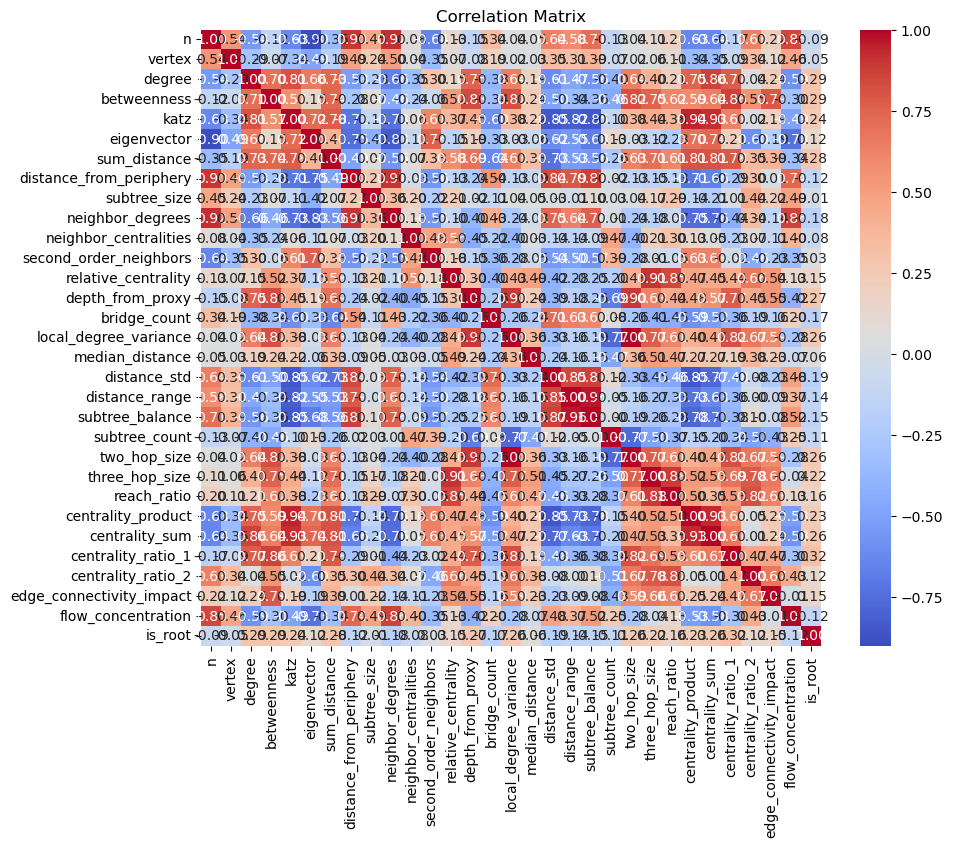

In [38]:
# check the carrelation between features
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['sentence', 'language'], axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [39]:
import pandas as pd

# Drop non-numeric columns
correlation_matrix = df.drop(['sentence', 'language'], axis=1).corr()

# Display as table
print(correlation_matrix.round(2))
correlation_matrix.round(2).to_csv("correlation_matrix.csv")



                             n  vertex  degree  betweenness  katz  \
n                         1.00    0.54   -0.54        -0.12 -0.63   
vertex                    0.54    1.00   -0.29        -0.07 -0.34   
degree                   -0.54   -0.29    1.00         0.70  0.81   
betweenness              -0.12   -0.07    0.70         1.00  0.57   
katz                     -0.63   -0.34    0.81         0.57  1.00   
eigenvector              -0.90   -0.49    0.66         0.15  0.72   
sum_distance             -0.35   -0.19    0.73         0.74  0.78   
distance_from_periphery   0.90    0.49   -0.53        -0.28 -0.71   
subtree_size              0.45    0.24   -0.23         0.07 -0.11   
neighbor_degrees          0.92    0.50   -0.66        -0.46 -0.73   
neighbor_centralities     0.08    0.04   -0.35        -0.24  0.06   
second_order_neighbors   -0.64   -0.35    0.30        -0.06  0.61   
relative_centrality       0.13    0.07    0.15         0.52  0.37   
depth_from_proxy         -0.15   -

## Resampling: Splitting Data into Train and Validation Set

To estimate the generalization error, we split the data into train and validation set. We will then use a 5-fold cross validation over the train set so we train over a good sample of the data

In [41]:
# separate features and target value
X = train_df.drop('is_root', axis=1)
y = train_df['is_root']


In [42]:
# to avoid data leakage use group split
from sklearn.model_selection import GroupShuffleSplit

# Grouping by sentence ID
groups = train_df['sentence'] 

# Perform group split (80% train, 20% val)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# Verify no sentence appears in both splits
train_sentences = set(groups.iloc[train_idx])
val_sentences = set(groups.iloc[val_idx])
assert train_sentences.isdisjoint(val_sentences), "Data leakage detected!"

## Per Sentence Normalization

It will be better to normalize the data since it has different different ranges. we have to do a sentence level normalization because different sentences have different number of nodes

Note: Group by language then sentence coz per sentence will scale all the sentences from all the languages as one. however for example, Arabic and Turkish trees for the same sentence may have different structures, so we Normalize per-language AND per-sentence by grouping by both language and sentence. treating them as a single group would mix languages during normalization.

In [45]:
from sklearn.preprocessing import MinMaxScaler

features = X_train.drop(['language', 'sentence', 'n', 'vertex'], axis=1).columns

def scaling(X):
    """
    Normalize features using MinMaxScaler
    """
    normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())
    X_ft= X.drop(features, axis=1) 
    normalized_X = pd.concat([X_ft, normalized_ft], axis=1)
    
    return normalized_X

X_train_normalized = scaling(X_train)
X_val_normalized = scaling(X_val)

C:\Users\nifeo\AppData\Local\Temp\ipykernel_21576\1461406940.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())
C:\Users\nifeo\AppData\Local\Temp\ipykernel_21576\1461406940.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())


we fit and transform the test set independently because the sentences are different in the two sets, so we can't use the scalers used for train to transform the test set, as we performed a within sentence normalization

We also only performed normalization on the centrality metrics and on the number of nodes n

In [47]:
# drop columns not useful
X_train_normalized = X_train_normalized.drop(['language', 'sentence', 'vertex'], axis=1)
X_val_normalized = X_val_normalized.drop(['language', 'sentence', 'vertex'], axis=1)

# Imbalance Handling 

We tried undersmapling and oversampling the data but it was not as helpful, so it will remain commented here

## Undersampling 

In [51]:
"""
import ast
import networkx as nx
from tqdm import tqdm

# Function to remove bottom 25% nodes by degree
def prune_low_degree_nodes(edgelist_str, retain_percent=0.75):
    edges = ast.literal_eval(edgelist_str)
    G = nx.Graph(edges)

    if len(G.nodes) == 0:
        return edges  # nothing to do

    # Sort nodes by degree
    degrees = dict(G.degree())
    sorted_nodes = sorted(degrees.items(), key=lambda x: x[1])
    
    # Keep top N% nodes
    keep_n = int(len(sorted_nodes) * retain_percent)
    keep_nodes = set([node for node, _ in sorted_nodes[-keep_n:]])
    
    # Filter edges
    pruned_edges = [(u, v) for u, v in edges if u in keep_nodes and v in keep_nodes]
    
    return pruned_edges

tqdm.pandas()
X_train_normalized = X_train_normalized.copy()
X_train_normalized['edgelist'] = X_train_normalized.progress_apply(
    lambda row: prune_low_degree_nodes(row['edgelist']) if row['language'] == major_class else row['edgelist'],
    axis=1
)
)
"""

"\nimport ast\nimport networkx as nx\nfrom tqdm import tqdm\n\n# Function to remove bottom 25% nodes by degree\ndef prune_low_degree_nodes(edgelist_str, retain_percent=0.75):\n    edges = ast.literal_eval(edgelist_str)\n    G = nx.Graph(edges)\n\n    if len(G.nodes) == 0:\n        return edges  # nothing to do\n\n    # Sort nodes by degree\n    degrees = dict(G.degree())\n    sorted_nodes = sorted(degrees.items(), key=lambda x: x[1])\n    \n    # Keep top N% nodes\n    keep_n = int(len(sorted_nodes) * retain_percent)\n    keep_nodes = set([node for node, _ in sorted_nodes[-keep_n:]])\n    \n    # Filter edges\n    pruned_edges = [(u, v) for u, v in edges if u in keep_nodes and v in keep_nodes]\n    \n    return pruned_edges\n\ntqdm.pandas()\nX_train_normalized = X_train_normalized.copy()\nX_train_normalized['edgelist'] = X_train_normalized.progress_apply(\n    lambda row: prune_low_degree_nodes(row['edgelist']) if row['language'] == major_class else row['edgelist'],\n    axis=1\n)\n)\n

## Oversampling

In [53]:
"""
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Step 1: Separate features and target
X_features = X_train_normalized.drop(columns=['target', 'language', 'sentence', 'node', 'group'])  # Keep only numerical features
y_target = train_df['target']

# Save identifier columns for later merge
identifier_cols = train_df[['language', 'sentence', 'node']].reset_index(drop=True)

# Step 2: Apply RandomOverSampler to balance the minority class (target == 1)
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_features, y_target)

# Step 3: Reattach metadata using sample indices
resampled_ids = identifier_cols.iloc[ros.sample_indices_].reset_index(drop=True)
resampled_data = pd.concat([
    resampled_ids,
    pd.DataFrame(X_balanced, columns=X_features.columns),
    pd.Series(y_balanced, name='target')
], axis=1)
"""


"\nfrom imblearn.over_sampling import RandomOverSampler\nimport pandas as pd\n\n# Step 1: Separate features and target\nX_features = X_train_normalized.drop(columns=['target', 'language', 'sentence', 'node', 'group'])  # Keep only numerical features\ny_target = train_df['target']\n\n# Save identifier columns for later merge\nidentifier_cols = train_df[['language', 'sentence', 'node']].reset_index(drop=True)\n\n# Step 2: Apply RandomOverSampler to balance the minority class (target == 1)\nros = RandomOverSampler(sampling_strategy='minority', random_state=42)\nX_balanced, y_balanced = ros.fit_resample(X_features, y_target)\n\n# Step 3: Reattach metadata using sample indices\nresampled_ids = identifier_cols.iloc[ros.sample_indices_].reset_index(drop=True)\nresampled_data = pd.concat([\n    resampled_ids,\n    pd.DataFrame(X_balanced, columns=X_features.columns),\n    pd.Series(y_balanced, name='target')\n], axis=1)\n"

## Modeling

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# Initialize with balanced class weights
rf = RandomForestClassifier(
      # Key: Auto-adjusts weights for the rare class
    random_state=42, n_estimators=200,        # Number of trees
    max_depth=100,             # Control overfitting (adjust based on tree size)
    min_samples_leaf=10, class_weight='balanced_subsample'
)
# Train
rf.fit(X_train_normalized, y_train)
y_pred = rf.predict(X_val_normalized)
print(classification_report(y_val, y_pred))

# Focus on F1-score for the root class
print(f"F1-Score (Root): {f1_score(y_val, y_pred, pos_label=1):.3f}")

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     37903
           1       0.28      0.50      0.36      2100

    accuracy                           0.91     40003
   macro avg       0.63      0.71      0.66     40003
weighted avg       0.93      0.91      0.92     40003

F1-Score (Root): 0.362


In [56]:
importances = rf.feature_importances_
dict(zip(X_train_normalized, importances))

{'n': 0.03907868563613332,
 'degree': 0.014268831443845125,
 'betweenness': 0.08228087350845477,
 'katz': 0.030185039590468227,
 'eigenvector': 0.06032299188213934,
 'sum_distance': 0.0471785253921197,
 'distance_from_periphery': 0.024877289167100667,
 'subtree_size': 0.016437542697839917,
 'neighbor_degrees': 0.06758566573598042,
 'neighbor_centralities': 0.01556835090820072,
 'second_order_neighbors': 0.01570866922668432,
 'relative_centrality': 0.011247549685632508,
 'depth_from_proxy': 0.02033127223138193,
 'bridge_count': 0.05166823242647295,
 'local_degree_variance': 0.02860786813246631,
 'median_distance': 0.014345232562756797,
 'distance_std': 0.015005324084898882,
 'distance_range': 0.03128925650386349,
 'subtree_balance': 0.012138448886882758,
 'subtree_count': 0.030832637360820696,
 'two_hop_size': 0.023708397540127293,
 'three_hop_size': 0.01802068409406764,
 'reach_ratio': 0.01858864008814807,
 'centrality_product': 0.018082776068363598,
 'centrality_sum': 0.02270042879910

### Linear Classifiers

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score

lg_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1],             # Regularization strength
    'penalty': ['l2'],                  # l1 requires solver='liblinear' or 'saga'
    'solver': ['lbfgs', 'liblinear'],                # 'lbfgs' supports l2 and multiclass
}

grid_search = GridSearchCV(
    estimator=lg_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',   
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])


# Train
logreg = grid_search.best_estimator_

# Predict
y_pred = logreg.predict(X_val_normalized)
y_probs = logreg.predict_proba(X_val_normalized)[:, 1]  # Probabilities for root class

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [59]:
# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score:", f1_score(y_val, y_pred))


Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.99      0.74      0.84     37903
           1       0.14      0.80      0.25      2100

    accuracy                           0.74     40003
   macro avg       0.56      0.77      0.54     40003
weighted avg       0.94      0.74      0.81     40003

Test F1 Score: 0.24509803921568626


In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

lda = LinearDiscriminantAnalysis()

param_grid = {
    'shrinkage': [None, 'auto'],  # You can also try float values with solver='lsqr'
    'solver': ['svd', 'lsqr']
}

grid_search = GridSearchCV(
    estimator=lda,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])

# Best model
lda_best = grid_search.best_estimator_

# Predictions
y_pred = lda_best.predict(X_val_normalized)
y_probs = lda_best.predict_proba(X_val_normalized)[:, 1]  # Probability of positive class


Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\nifeo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nifeo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nifeo\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nifeo\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py", line 629, in fit
    raise NotImple

In [61]:
from sklearn.metrics import classification_report, f1_score

# Evaluation for LDA
print("📌 Best Hyperparameters:", grid_search.best_params_)

print("\n📊 Classification Report (LDA):")
print(classification_report(y_val, y_pred, digits=4))

f1 = f1_score(y_val, y_pred)
print(f"\n🎯 F1 Score on Validation Set (LDA): {f1:.4f}")


📌 Best Hyperparameters: {'shrinkage': None, 'solver': 'svd'}

📊 Classification Report (LDA):
              precision    recall  f1-score   support

           0     0.9609    0.9665    0.9637     37903
           1     0.3243    0.2905    0.3065      2100

    accuracy                         0.9310     40003
   macro avg     0.6426    0.6285    0.6351     40003
weighted avg     0.9275    0.9310    0.9292     40003


🎯 F1 Score on Validation Set (LDA): 0.3065


## Non Linear Classifiers

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score

# Define KNN model
knn_model = KNeighborsClassifier()

# Hyperparameter grid for KNN
param_grid = {
    'n_neighbors': [1, 3, 5],
    'metric': ['euclidean', 'minkowski', 'manhattan']
}

# Grid search with GroupKFold
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])

# Best estimator
knn = grid_search.best_estimator_

# Predict
y_pred = knn.predict(X_val_normalized)

# Probabilities (only works if n_neighbors > 1)
y_probs = knn.predict_proba(X_val_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score:", f1_score(y_val, y_pred))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     37903
           1       0.21      0.22      0.21      2100

    accuracy                           0.92     40003
   macro avg       0.58      0.59      0.58     40003
weighted avg       0.92      0.92      0.92     40003

Test F1 Score: 0.21362886111766094


In [64]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(random_state=42, max_iter=500)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'solver': ['adam']
}

grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])

best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_val_normalized)
y_probs = best_mlp.predict_proba(X_val_normalized)[:, 1]

print("Best Parameters (MLP):", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score (MLP):", f1_score(y_val, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters (MLP): {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37903
           1       0.59      0.06      0.11      2100

    accuracy                           0.95     40003
   macro avg       0.77      0.53      0.54     40003
weighted avg       0.93      0.95      0.93     40003

Test F1 Score (MLP): 0.11211729193617939


In [65]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_model = QuadraticDiscriminantAnalysis()

param_grid = {
    'reg_param': [0.0, 0.1, 0.5]  # Regularization
}

grid_search = GridSearchCV(
    estimator=qda_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])

best_qda = grid_search.best_estimator_
y_pred = best_qda.predict(X_val_normalized)
y_probs = best_qda.predict_proba(X_val_normalized)[:, 1]

print("Best Parameters (QDA):", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score (QDA):", f1_score(y_val, y_pred))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters (QDA): {'reg_param': 0.1}
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     37903
           1       0.31      0.31      0.31      2100

    accuracy                           0.93     40003
   macro avg       0.64      0.64      0.64     40003
weighted avg       0.93      0.93      0.93     40003

Test F1 Score (QDA): 0.3122043519394513


C:\Users\nifeo\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [66]:
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()

# No real hyperparameters to tune in GNB, but wrap for consistency
param_grid = {}

grid_search = GridSearchCV(
    estimator=gnb_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])

best_gnb = grid_search.best_estimator_
y_pred = best_gnb.predict(X_val_normalized)
y_probs = best_gnb.predict_proba(X_val_normalized)[:, 1]

print("Best Parameters (GNB):", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score (GNB):", f1_score(y_val, y_pred))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters (GNB): {}
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     37903
           1       0.15      0.72      0.25      2100

    accuracy                           0.77     40003
   macro avg       0.57      0.75      0.56     40003
weighted avg       0.94      0.77      0.83     40003

Test F1 Score (GNB): 0.24905784040635753


In [67]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10]
}

grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])

best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_val_normalized)
y_probs = best_dt.predict_proba(X_val_normalized)[:, 1]

print("Best Parameters (Decision Tree):", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score (Decision Tree):", f1_score(y_val, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters (Decision Tree): {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     37903
           1       0.14      0.75      0.24      2100

    accuracy                           0.75     40003
   macro avg       0.56      0.75      0.55     40003
weighted avg       0.94      0.75      0.82     40003

Test F1 Score (Decision Tree): 0.24177010253642742


## Ensemble Methods

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline

# Initialize Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    n_jobs=-1  # Parallel processing
)

# Parameter grid for tuning
param_grid = {
    'n_estimators': [200, 250],       # Number of trees
    'max_depth': [20, 30, 50],      # Tree depth
    'min_samples_split': [5, 10],      # Minimum samples to split
    'min_samples_leaf': [6, 10],
}

# Group-aware GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),  # 10-fold grouped CV
    scoring='f1',                # Focus on F1 for root class
    n_jobs=-1,                   # Parallelize
    verbose=1
)

# Fit (ensure X_train doesn't contain 'sentence' column)
grid_search.fit(
    X_train_normalized,  # Exclude group identifier
    y_train,
    groups=X_train['sentence']  # Grouping key
)

# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred = best_rf.predict(X_val_normalized)
y_probs = best_rf.predict_proba(X_val_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score:", f1_score(y_val, y_pred))

# Feature Importance
importances = best_rf.feature_importances_
print("Feature Importances:", dict(zip(X_train_normalized, importances)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 250}
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     37903
           1       0.28      0.49      0.36      2100

    accuracy                           0.91     40003
   macro avg       0.63      0.71      0.66     40003
weighted avg       0.93      0.91      0.92     40003

Test F1 Score: 0.35985439417576703
Feature Importances: {'n': 0.038891078707408655, 'degree': 0.018077236390650626, 'betweenness': 0.0817059531193046, 'katz': 0.029490738591238463, 'eigenvector': 0.06212514573712242, 'sum_distance': 0.04541062303464228, 'distance_from_periphery': 0.025134812611661474, 'subtree_size': 0.016343722743145984, 'neighbor_degrees': 0.0688700876626924, 'neighbor_centralities': 0.015556388232704006, 'second_order_neighbors': 0.0156624009845797, 'relative_centrality': 0.01127660

## Fit the Chosen Model on Entire Train Test

In [71]:
X_normalized = scaling(X).drop(['language', 'sentence', 'vertex'], axis=1)
X_normalized.head(1)

C:\Users\nifeo\AppData\Local\Temp\ipykernel_21576\1461406940.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())


,n,degree,betweenness,katz,eigenvector,sum_distance,distance_from_periphery,subtree_size,neighbor_degrees,neighbor_centralities,...,subtree_count,two_hop_size,three_hop_size,reach_ratio,centrality_product,centrality_sum,centrality_ratio_1,centrality_ratio_2,edge_connectivity_impact,flow_concentration
0,21,0.0,0.0,0.629551,0.002494,0.254313,0.22093,1.0,1.0,1.0,...,1.0,0.0,0.2,0.25,0.25,0.2,0.0,0.31693,0.0,1.0


In [72]:
# Fit whole data
best_rf.fit(X_normalized, y)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=50,
                       min_samples_leaf=10, min_samples_split=5,
                       n_estimators=250, n_jobs=-1, random_state=42)

## Make Predictions on Test Set

In [75]:
# read test data
test_df = pd.read_csv('../data/test.csv')
X_test = preprocess(test_df)
test_normalized = scaling(X_test).drop(['language', 'sentence', 'vertex'], axis=1)

# Predictions
test_pred = best_rf.predict(test_normalized)
test_probs = best_rf.predict_proba(test_normalized)[:, 1]

X_test['probability'] = test_probs

df_max = X_test.loc[X_test.groupby(['language', 'sentence'])['probability'].idxmax()]

df_max = df_max[['language','sentence', 'vertex']].rename(columns={'vertex': 'root'}).reset_index(drop=True)


submission_df = test_df.merge(df_max, on=['language', 'sentence'], how='left')
submission_df = submission_df[['id', 'root']]

submission_df

,id,root
0,1,37
1,2,46
2,3,2
3,4,18
4,5,3
...,...,...
10390,10391,13
10391,10392,8
10392,10393,1
10393,10394,20


Feature Importance for Random Forests

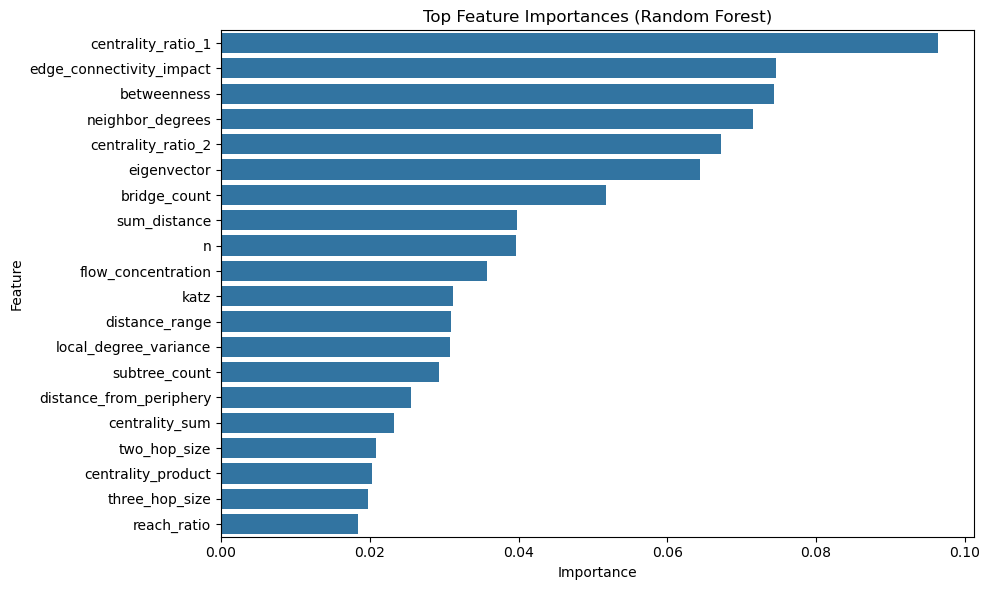

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances and names
importances = best_rf.feature_importances_
feature_names = test_normalized.columns  # Make sure to match this with your training feature names

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  # Show top 20
plt.title('Top Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


In [79]:

submission_df.to_csv('submission_randomforest_features_neww.csv', index=False)
print("Submission file created: submission_randomforest_features_neww.csv")


Submission file created: submission_randomforest_features_neww.csv


accuracy shouldnt be used as a metric when there is class imbalance

In [80]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Calculate class imbalance ratio
neg_pos_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"Class ratio (Non-Root:Root): {neg_pos_ratio:.1f}:1")

# Objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 300),
        'max_depth': trial.suggest_int('max_depth', 20, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
        'num_leaves': trial.suggest_int('num_leaves', 31, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'class_weight': {0: 1, 1: neg_pos_ratio},
        'random_state': 42,
        'n_jobs': -1
    }

    # Cross-validation
    gkf = GroupKFold(n_splits=5)
    f1_scores = []

    for train_idx, val_idx in gkf.split(X_train_normalized, y_train, groups=X_train['sentence']):
        X_tr, X_val = X_train_normalized.iloc[train_idx], X_train_normalized.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, pos_label=1)
        f1_scores.append(f1)

    return np.mean(f1_scores)

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Train best model
best_params = study.best_params
best_params.update({
    'class_weight': {0: 1, 1: neg_pos_ratio},
    'random_state': 42,
    'n_jobs': -1
})

lgb_model = LGBMClassifier(**best_params)
lgb_model.fit(X_train_normalized, y_train)

# Evaluate on validation/test set
y_pred = lgb_model.predict(X_val_normalized)
y_probs = lgb_model.predict_proba(X_val_normalized)[:, 1]

# Evaluation output
print("Best Parameters:", best_params)
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["Non-Root", "Root"]))
print(f"Test F1 Score (Root): {f1_score(y_val, y_pred, pos_label=1):.4f}")

# Feature importance
importances = lgb_model.feature_importances_
importance_dict = dict(zip(X_train_normalized.columns, importances))
print("\nTop Predictive Features:")
for feat, imp in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{feat}: {imp:.4f}")


[I 2025-05-24 03:29:55,994] A new study created in memory with name: no-name-cb5a47f4-808f-414a-a2d7-d21a2156d1c8


Class ratio (Non-Root:Root): 17.7:1


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 6720, number of negative: 119244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5028
[LightGBM] [Info] Number of data points in the train set: 125964, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500035 -> initscore=0.000141
[LightGBM] [Info] Start training from score 0.000141
[LightGBM] [Info] Number of positive: 6720, number of negative: 119273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4967
[LightGBM] [Info] Number of data points in the train set: 125993, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499974 -> initscore=-0.000102
[LightGBM] [Info] Start training from score -0.000102
[LightGBM] [